# Big Query Rai Data Acquisition and Analysis

In this notebook, we will query Rai system data from Google's Big Query and create the same datasets seen in (TheGraphDataSetCreation.ipynb)[TheGraphDataSetCreation.ipynb] with higher fidelity.


Access and libraries were was obtained by from the following tutorials:
* https://cloud.google.com/docs/authentication/getting-started#cloud-console
* https://cloud.google.com/bigquery/docs/pandas-gbq-migration


## Data Fields required (Data point: Big Query table)
* Total Supply
* Global Debt
* Redemption Price: OracleRelayer_event_UpdateRedemptionPrice
* Redemption Rate
* Debt ceiling
* Rai market price
* Total Collateral
* ETH Price (Next OSM): ChainlinkMedianETHUSD_event_UpdateResult
* Eth Price (OSM): OSM_event_UpdateResult
* System surplus
* Active safes
* Surplus
* Debt to settle
* Uniswap pool information


In [43]:
# import libraries
import os
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

%matplotlib inline

# constants
constant = 1000000000000000000

#defining creditionals
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/aclarkdata/Downloads/raidata-5e1723d42cf5.json'

# initializing agent
client = bigquery.Client()


In [44]:
# SQL query
sql = """
SELECT * 
FROM `blockchain-etl.ethereum_rai.ChainlinkMedianETHUSD_event_UpdateResult`
ORDER By block_timestamp DESC

"""

eth_price_next_OSM = client.query(sql).to_dataframe()

In [45]:
eth_price_next_OSM['ETH Price (Next OSM)'] = eth_price_next_OSM['medianPrice'].astype(float)/constant
del eth_price_next_OSM['medianPrice']

eth_price_next_OSM.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,lastUpdateTime,ETH Price (Next OSM)
0,2021-04-19 15:08:01+00:00,12271233,0xeb2a5dc15e601c1116876add33842c21595319a15e9e...,48,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618844881,2129.458042
1,2021-04-19 14:07:33+00:00,12270946,0x7da0480193071151144ffaf7cf92fd624d2bc40656d9...,47,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618841253,2219.590000
2,2021-04-19 12:49:28+00:00,12270590,0x0cc57cc1b88720bd73869bbc4c9a930acc1f1e80c87f...,180,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618836568,2244.796301
3,2021-04-19 11:38:10+00:00,12270259,0x5510eba853ce5d961e402714c83e9303cf553d672b75...,183,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618832290,2236.288682
4,2021-04-19 10:27:55+00:00,12269966,0x0f654a24665353b782f6975789dbc319412d61583cee...,103,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1618828075,2218.569789


In [46]:

# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.OSM_event_UpdateResult`
ORDER By block_timestamp DESC

"""

eth_price_OSM = client.query(sql).to_dataframe()
eth_price_OSM['ETH Price (OSM)'] = eth_price_OSM['newMedian'].astype(float)/constant
del eth_price_OSM['newMedian']

eth_price_OSM.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,lastUpdateTime,ETH Price (OSM)
0,2021-04-21 18:09:36+00:00,12285067,0x718355c2187ca76c6efc214e60a93f4526417149d1de...,345,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1619028000,2431.206350
1,2021-04-21 17:09:42+00:00,12284816,0xe9f7acfc3116d0b4dc17a8114264a1b96520cda427a4...,275,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1619024400,2450.530000
2,2021-04-21 16:09:39+00:00,12284535,0x6c9d8ba7c5a6192afaccd6ca69c9f17a205bd6c0a4e0...,189,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1619020800,2438.290000
3,2021-04-21 15:19:37+00:00,12284327,0x6d42ed648c0140be44e50b0588126f4f10f044f0e213...,46,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1619017200,2386.001325
4,2021-04-21 14:09:45+00:00,12284024,0x3f39b8c3a38463fe6eb8c406323982813b40695012fa...,179,0xe6f5377de93a361cd5531bdfbdf0f4b522e16b2b,1619013600,2372.290000


In [47]:
import json
import requests
url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'

blocknumbers = eth_price_OSM.block_number.values.tolist()

state = []
for i in blocknumbers:
    query = '''
    {
      systemState(block: {number:%s},id:"current") { 
        coinUniswapPair {
          reserve0
          reserve1
        }
        currentCoinMedianizerUpdate{
          value
        }
        currentRedemptionRate {
          eightHourlyRate
          annualizedRate
          hourlyRate
          createdAt
        }
        currentRedemptionPrice {
          value
        }
        erc20CoinTotalSupply
        globalDebt
        globalDebtCeiling
        totalActiveSafeCount
        coinAddress
        wethAddress
        systemSurplus
        debtAvailableToSettle
        lastPeriodicUpdate
        createdAt
        createdAtBlock
      }
    }
    ''' % i
    r = requests.post(url, json = {'query':query})
    s = json.loads(r.content)['data']['systemState']
    state.append(s)
        
systemState = pd.DataFrame(state)

systemState['block_number'] = blocknumbers


systemState.head()
    


,coinAddress,coinUniswapPair,createdAt,createdAtBlock,currentCoinMedianizerUpdate,currentRedemptionPrice,currentRedemptionRate,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,lastPeriodicUpdate,systemSurplus,totalActiveSafeCount,wethAddress,block_number
0,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '19857588.503276449364414436', 'r...",1529678381,5834717,{'value': '3.039306610555828619'},{'value': '3.016533906711977183933196363'},{'annualizedRate': '0.930716422387766409378098...,2407.254511111388003629651242726791,30581191.569238087804097134,30852072.69914329063907614885320641,115792089237316195423570985008687.9,1619028354,201993.2127900751869284789792445576,724,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12285067
1,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '19845588.503276449364414436', 'r...",1529678381,5834717,{'value': '3.039306610555828619'},{'value': '3.016533906711977183933196363'},{'annualizedRate': '0.930716422387766409378098...,2407.254511111388003629651242726791,30561398.569238087804097134,30833213.16446467148521813693768038,115792089237316195423570985008687.9,1619022258,201937.9947819183075107308211731559,722,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12284816
2,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '20127479.251947635073525577', 'r...",1529678381,5834717,{'value': '3.039306610555828619'},{'value': '3.016555832585458108723032111'},{'annualizedRate': '0.970169670805387549005755...,2407.254511111388003629651242726791,30823555.525391076424305542,31094041.45150361658347319753478293,115792089237316195423570985008687.9,1619017207,201884.8591054541350984743550324446,722,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12284535
3,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '20093718.173959421453671132', 'r...",1529678381,5834717,{'value': '3.039306610555828619'},{'value': '3.01656794134117022424243371'},{'annualizedRate': '0.970169670805387549005755...,2407.254511111388003629651242726791,30823555.525391076424305542,31094041.45150361658347319753478293,115792089237316195423570985008687.9,1619017207,201884.8591054541350984743550324446,722,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12284327
4,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '19864455.985574033576045016', 'r...",1529678381,5834717,{'value': '3.026185309818442722'},{'value': '3.016578355489326981745262859'},{'annualizedRate': '0.970169670805387549005755...,2407.254511111388003629651242726791,30673555.525391076424305542,30943694.30003156063725555250321439,115792089237316195423570985008687.9,1619010524,201819.8960832211202809465402261782,722,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,12284024


In [48]:
systemState.tail()

,coinAddress,coinUniswapPair,createdAt,createdAtBlock,currentCoinMedianizerUpdate,currentRedemptionPrice,currentRedemptionRate,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,lastPeriodicUpdate,systemSurplus,totalActiveSafeCount,wethAddress,block_number
1565,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '801.933726709008306816', 'reserv...",1529678381,5834717,{'value': '0'},{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,3048.440432971667032725,3048.645954953510904626288422086589,115792089237316195423570985008687.9,1613394096,0.1161617985274885650688366678947734,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861502
1566,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",1529678381,5834717,None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.657935201718685876567866781341,115792089237316195423570985008687.9,1613384616,0.1087511150258265757085590152709335,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861237
1567,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",1529678381,5834717,None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.657935201718685876567866781341,115792089237316195423570985008687.9,1613384616,0.1087511150258265757085590152709335,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861008
1568,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",1529678381,5834717,None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.522357955470745187436691184972,115792089237316195423570985008687.9,1613338681,0.06853325908830422221834559248594176,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11860755
1569,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,None,1529678381,5834717,None,None,None,0,0,0,0,0,0,0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11848351


In [49]:
systemState.columns

Index(['coinAddress', 'coinUniswapPair', 'createdAt', 'createdAtBlock',
       'currentCoinMedianizerUpdate', 'currentRedemptionPrice',
       'currentRedemptionRate', 'debtAvailableToSettle',
       'erc20CoinTotalSupply', 'globalDebt', 'globalDebtCeiling',
       'lastPeriodicUpdate', 'systemSurplus', 'totalActiveSafeCount',
       'wethAddress', 'block_number'],
      dtype='object')

In [50]:
systemState.drop(systemState.tail(1).index,inplace=True) # drop last row

systemState['coinUniswapPair'].tail()

1564    {'reserve0': '801.933726709008306816', 'reserv...
1565    {'reserve0': '801.933726709008306816', 'reserv...
1566    {'reserve0': '676.933726709008306816', 'reserv...
1567    {'reserve0': '676.933726709008306816', 'reserv...
1568    {'reserve0': '676.933726709008306816', 'reserv...
Name: coinUniswapPair, dtype: object

In [51]:
systemState['RedemptionRateAnnualizedRate'] = systemState.currentRedemptionRate.apply(lambda x: x['annualizedRate'])
systemState['RedemptionRateHourlyRate'] = systemState.currentRedemptionRate.apply(lambda x: x['hourlyRate'])
systemState['RedemptionRateEightHourlyRate'] = systemState.currentRedemptionRate.apply(lambda x: x['eightHourlyRate'])
systemState['RedemptionPrice'] = systemState.currentRedemptionPrice.apply(lambda x: x['value'])
systemState['RAIInUniswapV2(RAI/ETH)'] = systemState.coinUniswapPair.apply(lambda x: x['reserve0'])
del systemState['currentRedemptionRate']
del systemState['currentRedemptionPrice']
systemState['RedemptionRateAnnualizedRate'] = systemState['RedemptionRateAnnualizedRate'].astype(float)
systemState['RedemptionRateHourlyRate'] = systemState['RedemptionRateHourlyRate'].astype(float)
systemState['RedemptionRateEightHourlyRate'] = systemState['RedemptionRateEightHourlyRate'].astype(float)
systemState['RedemptionPrice'] = systemState['RedemptionPrice'].astype(float)
systemState['RAIInUniswapV2(RAI/ETH)'] = systemState['RAIInUniswapV2(RAI/ETH)'].astype(float)



In [52]:
len(systemState)

1569

In [53]:
len(eth_price_OSM)

1570

In [54]:
systemState['timestampDiff'] = systemState['createdAt'].astype(float).diff() * -1
systemState['timestampDiff'] = systemState['timestampDiff'][1:-2]
systemState['timestampDiff'].describe()

count    1566.0
mean        0.0
std         0.0
min        -0.0
25%        -0.0
50%        -0.0
75%        -0.0
max        -0.0
Name: timestampDiff, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


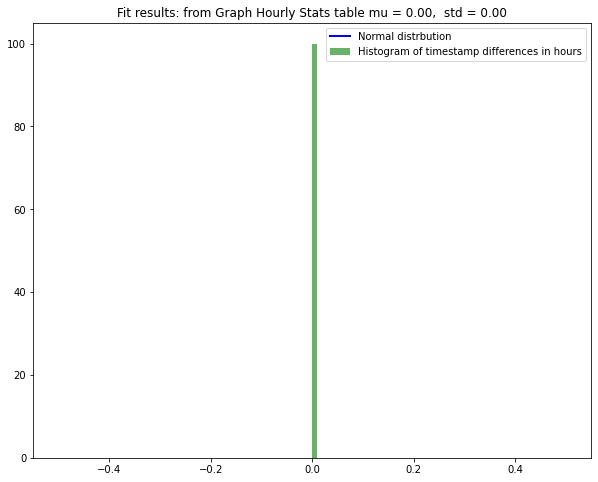

In [55]:
# convert to hours
data = systemState.timestampDiff[1:-3].apply(lambda x: x/3600)

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)
plt.figure(figsize=(10, 8))
# Plot the histogram.
plt.hist(data, bins=100, density=True, alpha=0.6, color='g',label='Histogram of timestamp differences in hours')

# Plot the PDF.
x = np.linspace(0, 3, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color = 'b',label ='Normal distrbution')
title = "Fit results: from Graph Hourly Stats table mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.legend()

plt.show()

## Time Analysis

In [56]:
eth_price_OSM['timestampDiff'] = eth_price_OSM['lastUpdateTime'].astype(float).diff() * -1
eth_price_OSM['timestampDiff'] = eth_price_OSM['timestampDiff'][1:-2]
eth_price_OSM['timestampDiff'].describe()

count    1567.0
mean     3600.0
std         0.0
min      3600.0
25%      3600.0
50%      3600.0
75%      3600.0
max      3600.0
Name: timestampDiff, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1760: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


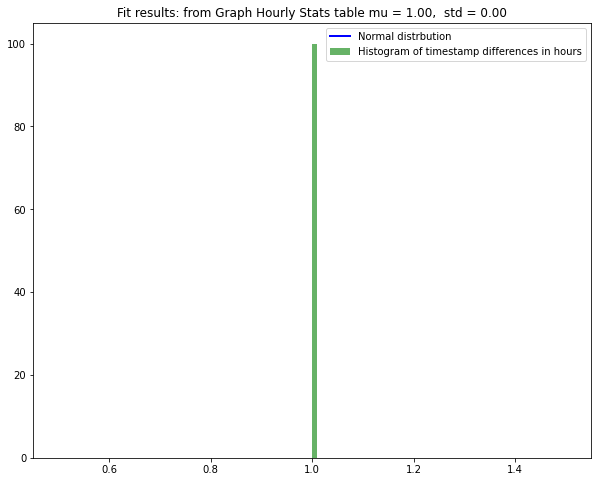

In [57]:
# convert to hours
data = eth_price_OSM.timestampDiff[1:-3].apply(lambda x: x/3600)

# Fit a normal distribution to the data:
mu, std = stats.norm.fit(data)
plt.figure(figsize=(10, 8))
# Plot the histogram.
plt.hist(data, bins=100, density=True, alpha=0.6, color='g',label='Histogram of timestamp differences in hours')

# Plot the PDF.
x = np.linspace(0, 3, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color = 'b',label ='Normal distrbution')
title = "Fit results: from Graph Hourly Stats table mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.legend()

plt.show()

In [58]:
subset_eth = eth_price_OSM[['ETH Price (OSM)','block_number']]

In [59]:
master = eth_price_next_OSM.merge(systemState,how='inner',on='block_number')
master = master.merge(subset_eth,how='inner',on='block_number')

In [60]:
master.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,lastUpdateTime,ETH Price (Next OSM),coinAddress,coinUniswapPair,createdAt,...,systemSurplus,totalActiveSafeCount,wethAddress,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH),timestampDiff,ETH Price (OSM)
0,2021-04-05 23:09:57+00:00,12182570,0x97d4f653d6913c9cc85b5498df332e895ef6d079b2c3...,282,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617664197,2104.170974,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '31041801.125122501466135463', 'r...",1529678381,...,187338.5959485606686820321694960594,984,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.893578,0.999987,0.999897,3.030509,3.104180e+07,-0.0,2117.650000
1,2021-04-02 20:09:56+00:00,12162180,0x54b61efbebaadaf3cc7df50be548ec642d427c78a566...,231,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617394196,2072.713775,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '32035699.997107805187441075', 'r...",1529678381,...,184264.3263143241582880245129434617,981,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.846295,0.999981,0.999848,3.033423,3.203570e+07,-0.0,2052.464741
2,2021-04-02 07:13:07+00:00,12158673,0xd1a62352415d08be52cd4cebfefd7811bb0f3c5093da...,259,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617347587,1998.000000,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '31509283.060081752223705783', 'r...",1529678381,...,183712.5657625425875127865653801174,983,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.911912,0.999989,0.999916,3.034000,3.150928e+07,-0.0,1991.766574
3,2021-03-29 12:09:57+00:00,12134065,0x7fa7fb984f80e92dcf64f523fb5ceac5c55cc331ffc5...,364,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1617019797,1777.289555,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '36225653.949187886673282187', 'r...",1529678381,...,179640.3035482553016037784209888087,999,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.242260,1.000025,1.000198,3.033300,3.622565e+07,-0.0,1767.251649
4,2021-03-25 20:09:47+00:00,12110194,0x3259bdf3aad1248337c27b9cba2ff9fb5127a89a0d6d...,41,0x6a4b575ba61d2fb86ad0ff5e5be286960580e71a,1616702987,1607.400000,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '34427813.290379045822885935', 'r...",1529678381,...,175617.172673347380380196043242654,993,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.395665,1.000038,1.000304,3.027886,3.442781e+07,-0.0,1602.851185


In [61]:
master.to_csv('Graph+BigQuerySystemData.csv')

## Additional

In [62]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.OracleRelayer_event_UpdateRedemptionPrice`
ORDER By block_timestamp DESC

"""

redemptionPrice = client.query(sql).to_dataframe()

redemptionPrice['RAI Redemption Price'] = redemptionPrice['redemptionPrice'].astype(float)/constant
del redemptionPrice['redemptionPrice']
redemptionPrice.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,RAI Redemption Price
0,2021-04-21 18:09:50+00:00,12285068,0x6b972375fc81a77e68d76aa560d1143e5b182d649d91...,354,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.016509e+09
1,2021-04-21 17:09:42+00:00,12284816,0xeefc27a8b8303798e1546e12a472c0f17d426d3d75c3...,276,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.016534e+09
2,2021-04-21 16:57:53+00:00,12284759,0x2039284f4568860a7156f1aaee3fd83f2102e7c88d65...,354,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.016539e+09
3,2021-04-21 16:11:29+00:00,12284543,0x2c8fde5c4420ada0bc845f4cb6a5bb1a6c38c000bea5...,336,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.016547e+09
4,2021-04-21 15:19:45+00:00,12284328,0xfff3e5db45f7b83fe1cc3ff04f8772a3f55a1234f311...,46,0x4ed9c0dca0479bc64d8f4eb3007126d5791f7851,3.016556e+09


In [63]:
redemptionPrice['RAI Redemption Price']

0       3.016509e+09
1       3.016534e+09
2       3.016539e+09
3       3.016547e+09
4       3.016556e+09
            ...     
2074    3.140000e+09
2075    3.140000e+09
2076    3.140000e+09
2077    3.140000e+09
2078    3.140000e+09
Name: RAI Redemption Price, Length: 2079, dtype: float64

In [64]:
systemState['RedemptionPrice']

0       3.016534
1       3.016534
2       3.016556
3       3.016568
4       3.016578
          ...   
1564    3.140000
1565    3.140000
1566    3.140000
1567    3.140000
1568    3.140000
Name: RedemptionPrice, Length: 1569, dtype: float64

## Safe events

All safe Big Query events:

### Un-used
* SAFEEngine_event_AddAuthorization
* SAFEEngine_event_ApproveSAFEModification 
* SAFEEngine_event_CreateUnbackedDebt
* SAFEEngine_event_DenySAFEModification
* SAFEEngine_event_DisableContract
* SAFEEngine_event_InitializeCollateralType
* SAFEEngine_event_RemoveAuthorization
* SAFEEngine_event_TransferSAFECollateralAndDebt


### Used:
* SAFEEngine_event_ConfiscateSAFECollateralAndDebt
* SAFEEngine_event_ModifyCollateralBalance
* SAFEEngine_event_ModifyParameters
* SAFEEngine_event_ModifySAFECollateralization
* SAFEEngine_event_SettleDebt
* SAFEEngine_event_TransferCollateral
* SAFEEngine_event_TransferInternalCoins
* SAFEEngine_event_UpdateAccumulatedRate

In [73]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_ConfiscateSAFECollateralAndDebt`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_ConfiscateSAFECollateralAndDebt = client.query(sql).to_dataframe()
SAFEEngine_event_ConfiscateSAFECollateralAndDebt['Event'] = 'SAFEEngine_event_ConfiscateSAFECollateralAndDebt'
SAFEEngine_event_ConfiscateSAFECollateralAndDebt.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,safe,collateralCounterparty,debtCounterparty,deltaCollateral,deltaDebt,globalUnbackedDebt,Event
0,2021-04-18 13:00:26+00:00,12264219,0x6087bae12fc44a7448e9a26bc02ceee93263530c5474...,35,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xd0d403427b1018fd47ff18911eab2fca914a8451,0x27efc6ffe79692e0521e7e27657cf228240a06c2,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,-2500000000000000000,-1199575073796859981982,3307254511111388003630653718953832290789070624990,SAFEEngine_event_ConfiscateSAFECollateralAndDebt
1,2021-04-14 11:00:07+00:00,12237813,0x6cdf928480223693fb4c865841832d5b150d9123cd78...,5,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x605f13ea976cb9fe9afb990301e1c545a3d3c0ad,0x27efc6ffe79692e0521e7e27657cf228240a06c2,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,-2220000000000000000,-1199623529590242599057,2103518374295953903228734667282724195848981712914,SAFEEngine_event_ConfiscateSAFECollateralAndDebt
2,2021-04-07 19:01:37+00:00,12194464,0x56672448531e1ca05a1af3da8a7cdb32949a8969f42a...,29,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x9652bbb5b9b056ba4a14ffe7b75eb9bd6fa1be5a,0x27efc6ffe79692e0521e7e27657cf228240a06c2,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,-2000000000000000000,-897411436975615760498,900000000000000000001002476227041394075821743724,SAFEEngine_event_ConfiscateSAFECollateralAndDebt
3,2021-03-24 21:00:16+00:00,12103880,0x80984fdcd2c61cd36ef4b500fc0c575f87575b8b1361...,61,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x0899634fb88cc1ff5d1f43ca087f0a709ac42a5f,0x27efc6ffe79692e0521e7e27657cf228240a06c2,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,-7000000000000000000,-2596958194905361160377,4975545276765162608995551015657265162886714670...,SAFEEngine_event_ConfiscateSAFECollateralAndDebt
4,2021-03-24 21:00:16+00:00,12103880,0x80984fdcd2c61cd36ef4b500fc0c575f87575b8b1361...,37,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xd519c4607bcf09dee539cadddc3f95a42b8864f0,0x27efc6ffe79692e0521e7e27657cf228240a06c2,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,-8000000000000000000,-2994577819959719388405,4715297040171254510218409556451870499235811035...,SAFEEngine_event_ConfiscateSAFECollateralAndDebt


In [74]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_ModifyCollateralBalance`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_ModifyCollateralBalance = client.query(sql).to_dataframe()
SAFEEngine_event_ModifyCollateralBalance['Event'] = 'SAFEEngine_event_ModifyCollateralBalance'
SAFEEngine_event_ModifyCollateralBalance.head()


,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,account,wad,Event
0,2021-04-21 18:05:54+00:00,12285048,0x1584d2012e4908dbef32f2bf734228e6e332b5210f43...,271,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xc1a7dc3aab51169a0ab086bdd3ded7f247151c63,3000000000000000000,SAFEEngine_event_ModifyCollateralBalance
1,2021-04-21 17:54:27+00:00,12285007,0x169021f3e5f9c913aa30c665079a94df18e8339ee602...,122,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xe53c2c6a119fa0b0d38c38ccdcd96e03640b9d1a,30000000000000000000,SAFEEngine_event_ModifyCollateralBalance
2,2021-04-21 17:43:04+00:00,12284953,0x10253e3a94277019c6a0d94f249013ee81af1f9ed56b...,101,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x72a4e26ae953397f5b72005fbe16e37c090b41f0,14000000000000000000,SAFEEngine_event_ModifyCollateralBalance
3,2021-04-21 16:44:07+00:00,12284698,0x6da42dab2f1bdee1911bdf6130dad59b51ec6a4d387a...,120,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x1f193322051c0f70e188f080c285edfb51598bf8,-1000000000000000000000,SAFEEngine_event_ModifyCollateralBalance
4,2021-04-21 16:41:03+00:00,12284683,0x932cd202bb91137bc3d9f134aa2fc2fc110c82cfa184...,221,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x7df3044b8f1b3c7b6a95f39972e8e18360da76d0,-182000000000000000000,SAFEEngine_event_ModifyCollateralBalance


In [76]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_ModifyParameters`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_ModifyParameters = client.query(sql).to_dataframe()
SAFEEngine_event_ModifyParameters['Event'] = 'SAFEEngine_event_ModifyParameters'
SAFEEngine_event_ModifyParameters.head()



,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,parameter,data,Event
0,2021-04-21 18:09:50+00:00,12285068,0x6b972375fc81a77e68d76aa560d1143e5b182d649d91...,355,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x73616665747950726963650000000000000000000000...,555839204743626234643547439661,SAFEEngine_event_ModifyParameters
1,2021-04-21 18:09:50+00:00,12285068,0x6b972375fc81a77e68d76aa560d1143e5b182d649d91...,356,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x6c69717569646174696f6e5072696365000000000000...,555839204743626234643547439661,SAFEEngine_event_ModifyParameters
2,2021-04-21 17:09:42+00:00,12284816,0xeefc27a8b8303798e1546e12a472c0f17d426d3d75c3...,278,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x6c69717569646174696f6e5072696365000000000000...,560252508978854955445950981726,SAFEEngine_event_ModifyParameters
3,2021-04-21 17:09:42+00:00,12284816,0xeefc27a8b8303798e1546e12a472c0f17d426d3d75c3...,277,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x73616665747950726963650000000000000000000000...,560252508978854955445950981726,SAFEEngine_event_ModifyParameters
4,2021-04-21 16:11:29+00:00,12284543,0x2c8fde5c4420ada0bc845f4cb6a5bb1a6c38c000bea5...,338,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x6c69717569646174696f6e5072696365000000000000...,557451748327546276539392045213,SAFEEngine_event_ModifyParameters


In [77]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_ModifySAFECollateralization`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_ModifySAFECollateralization = client.query(sql).to_dataframe()
SAFEEngine_event_ModifySAFECollateralization['Event'] = 'SAFEEngine_event_ModifySAFECollateralization'
SAFEEngine_event_ModifySAFECollateralization.head()



,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,safe,collateralSource,debtDestination,deltaCollateral,deltaDebt,lockedCollateral,generatedDebt,globalDebt,Event
0,2021-04-21 18:05:54+00:00,12285048,0x1584d2012e4908dbef32f2bf734228e6e332b5210f43...,274,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xc93c13b6482107ee5868a23e7389124c892024cb,0xc1a7dc3aab51169a0ab086bdd3ded7f247151c63,0xc1a7dc3aab51169a0ab086bdd3ded7f247151c63,3000000000000000000,0,3000000000000000000,0,3085126229921583594047716840681510835445202819...,SAFEEngine_event_ModifySAFECollateralization
1,2021-04-21 18:05:54+00:00,12285048,0x1584d2012e4908dbef32f2bf734228e6e332b5210f43...,280,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xc93c13b6482107ee5868a23e7389124c892024cb,0xc93c13b6482107ee5868a23e7389124c892024cb,0xc93c13b6482107ee5868a23e7389124c892024cb,0,797091949053127830704,3000000000000000000,797091949053127830704,3085207560719423751124544531093779475500784094...,SAFEEngine_event_ModifySAFECollateralization
2,2021-04-21 17:54:27+00:00,12285007,0x169021f3e5f9c913aa30c665079a94df18e8339ee602...,131,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x91dac5659796372dc1f95c839fb65c49b18c9dc2,0x91dac5659796372dc1f95c839fb65c49b18c9dc2,0x91dac5659796372dc1f95c839fb65c49b18c9dc2,0,11956384393694557434295,30000000000000000000,11956384393694557434295,3085126229921583594047716840681510835445202819...,SAFEEngine_event_ModifySAFECollateralization
3,2021-04-21 17:54:27+00:00,12285007,0x169021f3e5f9c913aa30c665079a94df18e8339ee602...,125,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x91dac5659796372dc1f95c839fb65c49b18c9dc2,0xe53c2c6a119fa0b0d38c38ccdcd96e03640b9d1a,0xe53c2c6a119fa0b0d38c38ccdcd96e03640b9d1a,30000000000000000000,0,30000000000000000000,0,3083924907387428781966015502682218641930349381...,SAFEEngine_event_ModifySAFECollateralization
4,2021-04-21 17:43:04+00:00,12284953,0x10253e3a94277019c6a0d94f249013ee81af1f9ed56b...,110,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xa6fb10e369c5a1cc767af1b16ae03d47e90b4f22,0xa6fb10e369c5a1cc767af1b16ae03d47e90b4f22,0xa6fb10e369c5a1cc767af1b16ae03d47e90b4f22,0,6967585993690824139526,30400000000000000000,12460003104660991909620,3083924907387428781966015502682218641930349381...,SAFEEngine_event_ModifySAFECollateralization


In [78]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_SettleDebt`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_SettleDebt = client.query(sql).to_dataframe()
SAFEEngine_event_SettleDebt['Event'] ='SAFEEngine_event_SettleDebt'
SAFEEngine_event_SettleDebt.head()





,block_timestamp,block_number,transaction_hash,log_index,contract_address,account,rad,debtBalance,coinBalance,globalUnbackedDebt,globalDebt,Event
0,2021-04-19 19:18:03+00:00,12272342,0xa2e25da20dfa5e9661688a6306d30e188fa643a34793...,272,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,900000000000000000001002476227041394075821743724,2407254511111388003629651242726790896713248881266,2027222635903069537228225155558321180668950003...,2407254511111388003629651242726790896713248881266,3032703826686624218402396798085518690594436681...,SAFEEngine_event_SettleDebt
1,2021-04-05 21:18:09+00:00,12182046,0x1f34492ec163ced86ef574826e6c9287b9bfb595244f...,264,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,5603430161389239180606453093315274126512479833728,0,1872558497830529247947215752867020300254022494...,0,3589662694365543038392278353146660187958136633...,SAFEEngine_event_SettleDebt
2,2021-04-03 21:18:56+00:00,12168983,0xd151b8e0ea6f43b3455217c6aafb42df6fbc18ddc528...,327,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,6000429200374285858342000749775368314273311672578,5603430161389239180606453093315274126512479833728,1908979296633846669850130065783923262184556123...,5603430161389239180606453093315274126512479833728,3550250021126473512710125816323988061362216357...,SAFEEngine_event_SettleDebt
3,2021-04-03 10:21:01+00:00,12166026,0xd1aa757fc323f0835804dfbcc433dce30bd96878b880...,199,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,2040000000000000000000595693274620755795645070848,1160385936176352503894845384309064244078579150...,1964650467937389117898754004998698561610466825...,1160385936176352503894845384309064244078579150...,3708530227106896330512529742600356102876252871...,SAFEEngine_event_SettleDebt
4,2021-03-30 21:20:02+00:00,12143061,0x4d66fc12a8209942e5a08badb1ee0f763eba0125d695...,164,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,1100934600698521085745993816089276959984553926...,1364385936176352503894904953636526319658143657...,1948605847847076926176144730913067974503822186...,1364385936176352503894904953636526319658143657...,4034279204888003783910996456420177383957056276...,SAFEEngine_event_SettleDebt


In [79]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_TransferCollateral`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_TransferCollateral = client.query(sql).to_dataframe()
SAFEEngine_event_TransferCollateral['Event'] = 'SAFEEngine_event_TransferCollateral'
SAFEEngine_event_TransferCollateral.head()







,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,src,dst,wad,Event
0,2021-04-21 16:44:07+00:00,12284698,0x6da42dab2f1bdee1911bdf6130dad59b51ec6a4d387a...,118,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x126261482eedecb780676e6e1a27065dba8be325,0x1f193322051c0f70e188f080c285edfb51598bf8,1000000000000000000000,SAFEEngine_event_TransferCollateral
1,2021-04-21 16:41:03+00:00,12284683,0x932cd202bb91137bc3d9f134aa2fc2fc110c82cfa184...,219,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xe349b0e640933e57bb96ef3c0f64fb22ba88fdfb,0x7df3044b8f1b3c7b6a95f39972e8e18360da76d0,182000000000000000000,SAFEEngine_event_TransferCollateral
2,2021-04-21 09:20:32+00:00,12282724,0x4a7097dfde5abad7377d1934c33b63606f09d9fdaa1f...,146,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x05dda58a5536a6741068a31e1258a64d14902b5d,0x49445648441db1594bf29deded257645934f9849,18000000000000000000,SAFEEngine_event_TransferCollateral
3,2021-04-21 06:20:47+00:00,12281937,0x00b57868f0a2aeb8436f3539731200d94f1d57bf4907...,54,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xc91bd40e70f793c1041069af7f78458c1203ce0d,0xc7fb31b91d2645f708db3f59ddc4356f1db9d1e6,13000000000000000000,SAFEEngine_event_TransferCollateral
4,2021-04-21 06:16:16+00:00,12281909,0x7fe97e73aecfc090e9457cba6e6665d3464e1cf574a6...,257,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xf69d5e851721a41176ebf32486c498d03f3cfb8e,0x85101eed614c1af50ea17c1193fc2ed8365a8aca,3000000000000000000,SAFEEngine_event_TransferCollateral


In [80]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_TransferInternalCoins`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_TransferInternalCoins = client.query(sql).to_dataframe()
SAFEEngine_event_TransferInternalCoins['Event'] = 'SAFEEngine_event_TransferInternalCoins'
SAFEEngine_event_TransferInternalCoins.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,src,dst,rad,Event
0,2021-04-21 18:05:54+00:00,12285048,0x1584d2012e4908dbef32f2bf734228e6e332b5210f43...,282,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xc93c13b6482107ee5868a23e7389124c892024cb,0xc1a7dc3aab51169a0ab086bdd3ded7f247151c63,800000000000000000000000000000000000000000000000,SAFEEngine_event_TransferInternalCoins
1,2021-04-21 18:05:54+00:00,12285048,0x1584d2012e4908dbef32f2bf734228e6e332b5210f43...,285,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xc1a7dc3aab51169a0ab086bdd3ded7f247151c63,0x0a5653cca4db1b6e265f47caf6969e64f1cfdc45,800000000000000000000000000000000000000000000000,SAFEEngine_event_TransferInternalCoins
2,2021-04-21 17:54:27+00:00,12285007,0x169021f3e5f9c913aa30c665079a94df18e8339ee602...,135,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0xe53c2c6a119fa0b0d38c38ccdcd96e03640b9d1a,0x0a5653cca4db1b6e265f47caf6969e64f1cfdc45,1200000000000000000000000000000000000000000000...,SAFEEngine_event_TransferInternalCoins
3,2021-04-21 17:54:27+00:00,12285007,0x169021f3e5f9c913aa30c665079a94df18e8339ee602...,133,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x91dac5659796372dc1f95c839fb65c49b18c9dc2,0xe53c2c6a119fa0b0d38c38ccdcd96e03640b9d1a,1200000000000000000000000000000000000000000000...,SAFEEngine_event_TransferInternalCoins
4,2021-04-21 17:43:04+00:00,12284953,0x10253e3a94277019c6a0d94f249013ee81af1f9ed56b...,114,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x72a4e26ae953397f5b72005fbe16e37c090b41f0,0x0a5653cca4db1b6e265f47caf6969e64f1cfdc45,6993000000000000000000000000000000000000000000000,SAFEEngine_event_TransferInternalCoins


In [81]:
# SQL query
sql = """
SELECT 
* 
FROM `blockchain-etl.ethereum_rai.SAFEEngine_event_UpdateAccumulatedRate`
ORDER By block_timestamp DESC

"""

SAFEEngine_event_UpdateAccumulatedRate = client.query(sql).to_dataframe()
SAFEEngine_event_UpdateAccumulatedRate['Event'] = 'SAFEEngine_event_UpdateAccumulatedRate'
SAFEEngine_event_UpdateAccumulatedRate.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,surplusDst,rateMultiplier,dstCoinBalance,globalDebt,Event
0,2021-04-21 18:05:54+00:00,12285048,0x1584d2012e4908dbef32f2bf734228e6e332b5210f43...,277,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,216483309644999481910,2044004673011865749321086304872844007292258916...,3085127560719423751124544485320640562960110380...,SAFEEngine_event_UpdateAccumulatedRate
1,2021-04-21 18:05:54+00:00,12285048,0x1584d2012e4908dbef32f2bf734228e6e332b5210f43...,275,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x83533fdd3285f48204215e9cf38c785371258e76,216483309644999481910,6137334008325584903980656674162686749674342920...,3085126895320503672586130663001075699202656600...,SAFEEngine_event_UpdateAccumulatedRate
2,2021-04-21 17:54:27+00:00,12285007,0x169021f3e5f9c913aa30c665079a94df18e8339ee602...,126,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0x83533fdd3285f48204215e9cf38c785371258e76,215222761118358054670,6136668609405506365566834354597822992220562466...,3083925568654506188006866214677111332373513524...,SAFEEngine_event_UpdateAccumulatedRate
3,2021-04-21 17:54:27+00:00,12285007,0x169021f3e5f9c913aa30c665079a94df18e8339ee602...,128,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,215222761118358054670,2043938133119857895479704072916357631546880870...,3083926229921583594047716926672004022816677668...,SAFEEngine_event_UpdateAccumulatedRate
4,2021-04-21 17:43:04+00:00,12284953,0x10253e3a94277019c6a0d94f249013ee81af1f9ed56b...,107,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,1365701284624826899998,2043872006412117291394632873427088587230466511...,3083225607387428781966015516288656639747487647...,SAFEEngine_event_UpdateAccumulatedRate


In [83]:
safe_events = [SAFEEngine_event_ConfiscateSAFECollateralAndDebt,SAFEEngine_event_ModifyCollateralBalance,
               SAFEEngine_event_ModifyParameters,SAFEEngine_event_ModifySAFECollateralization,
               SAFEEngine_event_SettleDebt,SAFEEngine_event_TransferCollateral,
               SAFEEngine_event_TransferInternalCoins,SAFEEngine_event_UpdateAccumulatedRate]


safe_events_df = pd.concat(safe_events)
safe_events_df.sort_values('block_number',ascending=True, inplace=True)
safe_events_df.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,safe,collateralCounterparty,debtCounterparty,deltaCollateral,...,generatedDebt,globalDebt,rad,debtBalance,coinBalance,src,dst,surplusDst,rateMultiplier,dstCoinBalance
3291,2021-02-13 15:04:39+00:00,11849002,0xc0c9d3fc5053eedaac684cc5b8092698cf968e9edf9b...,19,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3290,2021-02-13 15:06:41+00:00,11849011,0x8641f4ef2d9a84a9d9d1bfb09fc0a1fd11eff0d7c8e6...,110,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3289,2021-02-13 15:08:51+00:00,11849022,0xe313271188492c4cb881c814c2ce2797f638c56c4f01...,8,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3288,2021-02-13 15:08:51+00:00,11849022,0xe313271188492c4cb881c814c2ce2797f638c56c4f01...,9,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6617,2021-02-13 15:27:32+00:00,11849101,0x9e3ac87fc0e364f24a9a2bca9649bf12c876b9167851...,40,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
safe_events_df.tail()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,collateralType,safe,collateralCounterparty,debtCounterparty,deltaCollateral,...,generatedDebt,globalDebt,rad,debtBalance,coinBalance,src,dst,surplusDst,rateMultiplier,dstCoinBalance
0,2021-04-21 18:05:54+00:00,12285048,0x1584d2012e4908dbef32f2bf734228e6e332b5210f43...,277,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,3085127560719423751124544485320640562960110380...,NaN,NaN,NaN,NaN,NaN,0xcee6aa1ab47d0fb0f24f51a3072ec16e20f90fce,216483309644999481910,2044004673011865749321086304872844007292258916...
0,2021-04-21 18:05:54+00:00,12285048,0x1584d2012e4908dbef32f2bf734228e6e332b5210f43...,282,0xcc88a9d330da1133df3a7bd823b95e52511a6962,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,800000000000000000000000000000000000000000000000,NaN,NaN,0xc93c13b6482107ee5868a23e7389124c892024cb,0xc1a7dc3aab51169a0ab086bdd3ded7f247151c63,NaN,NaN,NaN
1,2021-04-21 18:05:54+00:00,12285048,0x1584d2012e4908dbef32f2bf734228e6e332b5210f43...,285,0xcc88a9d330da1133df3a7bd823b95e52511a6962,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,800000000000000000000000000000000000000000000000,NaN,NaN,0xc1a7dc3aab51169a0ab086bdd3ded7f247151c63,0x0a5653cca4db1b6e265f47caf6969e64f1cfdc45,NaN,NaN,NaN
1,2021-04-21 18:09:50+00:00,12285068,0x6b972375fc81a77e68d76aa560d1143e5b182d649d91...,356,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2021-04-21 18:09:50+00:00,12285068,0x6b972375fc81a77e68d76aa560d1143e5b182d649d91...,355,0xcc88a9d330da1133df3a7bd823b95e52511a6962,0x4554482d410000000000000000000000000000000000...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
safe_events_df.describe()

,block_number,log_index
count,4.195500e+04,41955.000000
mean,1.200572e+07,176.008175
std,1.216113e+05,85.611357
min,1.184900e+07,0.000000
25%,1.190426e+07,108.000000
50%,1.196066e+07,177.000000
75%,1.208832e+07,243.000000
max,1.228507e+07,562.000000


In [88]:
safe_events_df.to_hdf('safe_events.h5', key='df', mode='w')

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['transaction_hash', 'contract_address', 'collateralType', 'safe',
       'collateralCounterparty', 'debtCounterparty', 'deltaCollateral',
       'deltaDebt', 'globalUnbackedDebt', 'Event', 'account', 'wad',
       'parameter', 'data', 'collateralSource', 'debtDestination',
       'lockedCollateral', 'generatedDebt', 'globalDebt', 'rad', 'debtBalance',
       'coinBalance', 'src', 'dst', 'surplusDst', 'rateMultiplier',
       'dstCoinBalance'],
      dtype='object')]

  pytables.to_hdf(
